In [1]:
## 방법 2-1 : 모든 사용 가능한 GPU List 보기
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12525663989997124218
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10075463680
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3963275692851167996
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pylab as plt

In [4]:
seq = keras.Sequential(
    [
        keras.Input(shape=(None, 40, 40, 1)  ),
        # (time, rows, cols, channels)
        # 이 중, time을 지정하지 가변으로 두고, (None, 40,40,1) shape의 프레임을 입력받습니다.
        # 40x40에 1채널을 가지는 프레임입니다.
        
        layers.ConvLSTM2D(
            filters=40, kernel_size=(3, 3), padding="same", return_sequences=True
        ),
        layers.BatchNormalization(),
        
      
        layers.BatchNormalization(),
        layers.Conv3D(
            filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        ),
    ]
)
seq.compile(loss="binary_crossentropy", optimizer="adadelta")
 

In [5]:
seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, None, 40, 40, 40)  59200     
                                                                 
 batch_normalization (BatchN  (None, None, 40, 40, 40)  160      
 ormalization)                                                   
                                                                 
 batch_normalization_1 (Batc  (None, None, 40, 40, 40)  160      
 hNormalization)                                                 
                                                                 
 conv3d (Conv3D)             (None, None, 40, 40, 1)   1081      
                                                                 
Total params: 60,601
Trainable params: 60,441
Non-trainable params: 160
_________________________________________________________________


In [6]:
def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    
    # 인위적으로 만들 영화가 담길 배열을 선언
    # noisy라고 한 이유는 noisy를 추가한 영화를 만들 것이기 때문입니다. 
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
    
    # 한 프레임 이동한 값(정답값)을 담고 있는 배열입니다.
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)

    for i in range(n_samples): # 영화 샘플수만큼 반복

        # 랜덤하게 프레임 속 사각형의 개수를 정합니다. 여기서는 3~7개 중 랜덤하게 개수를 정합니다. 
        n = np.random.randint(3, 8)

        for j in range(n): # 사각형 개수만큼 반복

            # 초기 위치를 랜덤하게 지정합니다. 그 범위는 x,y축 모두 20이상 60미만 사이입니다.
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            
            # 이동 방향을 랜덤하게 지정합니다.
            # x,y 축 모두를 고려하면 3x3의 총 9가지입니다.
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1


            # 사각형의 크기를 랜덤하게 정합니다. 2 또는 3의 크기
            w = np.random.randint(2, 4)

            for t in range(n_frames): # 프레임 수 만큼 반복
            	
                # 이동후 좌표
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                
                # i번째 샘플의, t번째 프레임에서, 이동 후 좌표를 기준으로 사각형을 채웁니다.
                # 맨 마지막 0은, 이 영상의 채널은 1채널이기 때문에 0이라고 한 것입니다.
                noisy_movies[
                    i, 
                    t, 
                    x_shift - w : x_shift + w, 
                    y_shift - w : y_shift + w, 
                    0
                ] += 1

   
                # robust한 모델을 만들기 위해 noise를 추가해줍니다.
                # 추론 동안에 정확하게 1이 아니더라도 1가 가까운 값이라면
                # 여전히 사각형에 속한다고 간주하도록 하기 위함입니다.           
  
                
                # 0과 1중 랜덤하게 고를 때, 만약 1이라면 노이즈를 쥽니다.
                if np.random.randint(0, 2):
                	
                    # noise_f가 가질 수 있는 값: 1 또는 -1
                    noise_f = (-1) ** np.random.randint(0, 2)
                    
                    # 위에서 추가한 프레임에서,
                    # 사각형보다 상,하,좌,우 각각 1씩 더 큰 사각형에 (가로,세로 모두 2씩 증가)
                    noisy_movies[
                        i,
                        t,
                        x_shift - w - 1 : x_shift + w + 1,
                        y_shift - w - 1 : y_shift + w + 1,
                        0,
                    ] += (noise_f * 0.1) 
                    # 결과적으로 0.1 또는 -0.1씩 노이즈를 추가하는 셈입니다.
                
                
                # 정답 값을 담습니다.
                # 우리가 만든 이미지에서 한프레임씩 앞으로 간 영상입니다.
                # 여기는 노이즈가 추가되지 않습니다.
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[
                    i, 
                    t, 
                    x_shift - w : x_shift + w, 
                    y_shift - w : y_shift + w, 
                    0
                ] += 1

    # 80x80 영상 중 가운데 40x40범위만 사용합니다.
    # 굳이 이렇게 한 이유는 영상을 처음부터 작게 만들면 인덱스 에러가 발생할 가능성이 있기 때문에
    # 편의상 크게 만들고, 잘라서 사용하는 것입니다. 특별한 이유는 없습니다.
     
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    
    # 아까 노이즈를 0.1를 주면서 실제 값이 1.1로 변한 경우가 있기 때문에
    # 1.1을 다시 1로 돌려놓는 것입니다.
    
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    return noisy_movies, shifted_movies

In [7]:
noisy_movies, shifted_movies = generate_movies(n_samples=100)


C:\Users\ebdl\AppData\Local\Temp\ipykernel_25156\1862363226.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  noisy_movies = np.zeros((n_samples, n_frames, row, col, 1), dtype=np.float)
C:\Users\ebdl\AppData\Local\Temp\ipykernel_25156\1862363226.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  shifted_movies = np.zeros((n_samples, n

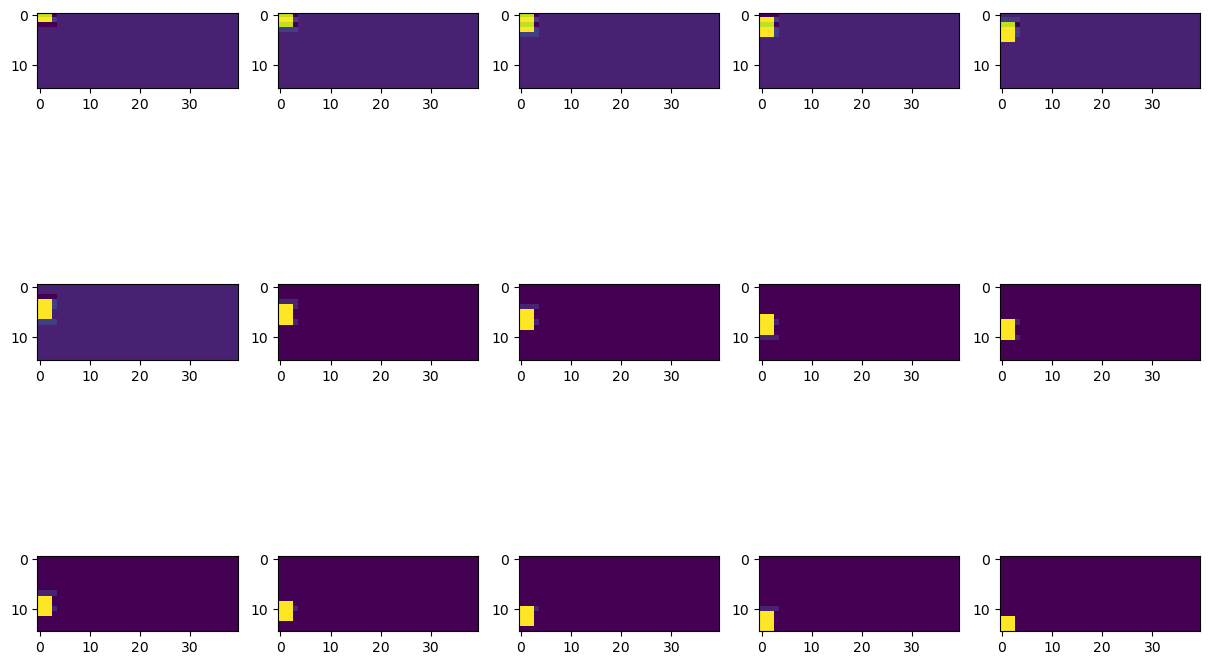

In [8]:
# 첫번째 샘플의 프레임 확인
plt.figure(figsize=(15,10))
plt.subplot(351)
plt.imshow(noisy_movies[0,:,:,0])
plt.subplot(352)
plt.imshow(noisy_movies[0,:,:,1])
plt.subplot(353)
plt.imshow(noisy_movies[0,:,:,2])
plt.subplot(354)
plt.imshow(noisy_movies[0,:,:,3])
plt.subplot(355)
plt.imshow(noisy_movies[0,:,:,4])
plt.subplot(356)
plt.imshow(noisy_movies[0,:,:,5])
plt.subplot(357)
plt.imshow(noisy_movies[0,:,:,6])
plt.subplot(358)
plt.imshow(noisy_movies[0,:,:,7])
plt.subplot(359)
plt.imshow(noisy_movies[0,:,:,8])
plt.subplot(3,5,10)
plt.imshow(noisy_movies[0,:,:,9])
plt.subplot(3,5,11)
plt.imshow(noisy_movies[0,:,:,10])
plt.subplot(3,5,12)
plt.imshow(noisy_movies[0,:,:,11])
plt.subplot(3,5,13)
plt.imshow(noisy_movies[0,:,:,12])
plt.subplot(3,5,14)
plt.imshow(noisy_movies[0,:,:,13])
plt.subplot(3,5,15)
plt.imshow(noisy_movies[0,:,:,14])

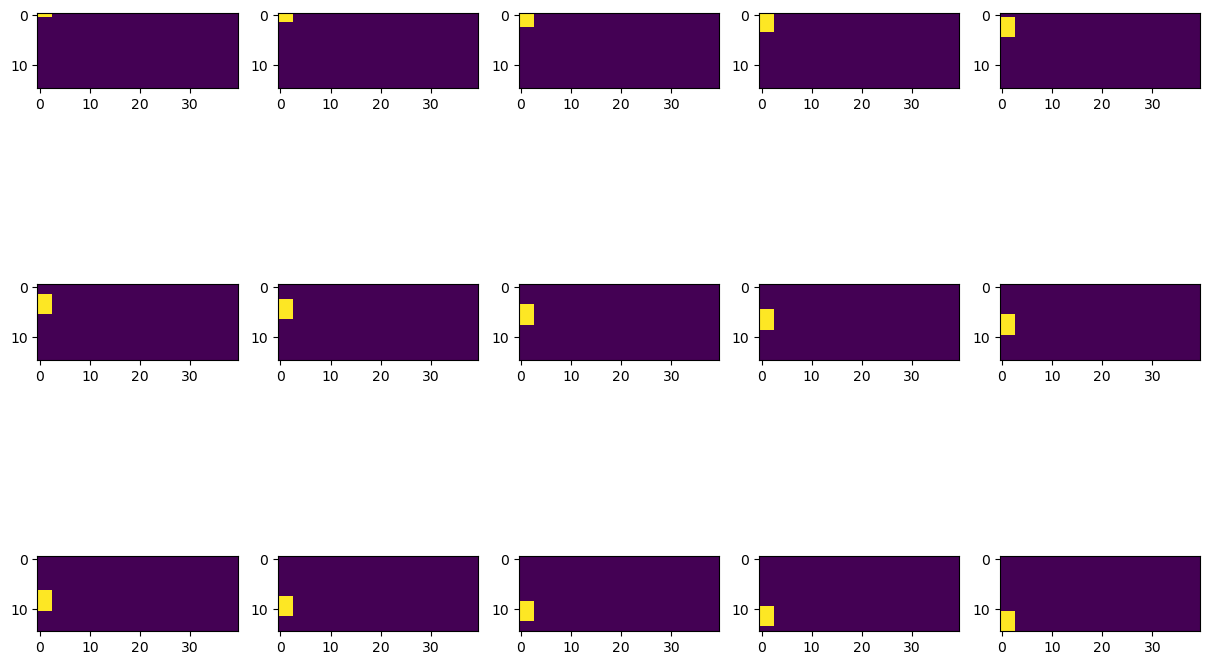

In [9]:
# 첫번째 샘플의 프레임 확인
plt.figure(figsize=(15,10))
plt.subplot(351)
plt.imshow(shifted_movies[0,:,:,0])
plt.subplot(352)
plt.imshow(shifted_movies[0,:,:,1])
plt.subplot(353)
plt.imshow(shifted_movies[0,:,:,2])
plt.subplot(354)
plt.imshow(shifted_movies[0,:,:,3])
plt.subplot(355)
plt.imshow(shifted_movies[0,:,:,4])
plt.subplot(356)
plt.imshow(shifted_movies[0,:,:,5])
plt.subplot(357)
plt.imshow(shifted_movies[0,:,:,6])
plt.subplot(358)
plt.imshow(shifted_movies[0,:,:,7])
plt.subplot(359)
plt.imshow(shifted_movies[0,:,:,8])
plt.subplot(3,5,10)
plt.imshow(shifted_movies[0,:,:,9])
plt.subplot(3,5,11)
plt.imshow(shifted_movies[0,:,:,10])
plt.subplot(3,5,12)
plt.imshow(shifted_movies[0,:,:,11])
plt.subplot(3,5,13)
plt.imshow(shifted_movies[0,:,:,12])
plt.subplot(3,5,14)
plt.imshow(shifted_movies[0,:,:,13])
plt.subplot(3,5,15)
plt.imshow(shifted_movies[0,:,:,14])

In [10]:
seq.fit(
    noisy_movies[:100],
    shifted_movies[:100],
    batch_size=2,
    epochs=1,
    verbose=0,
    validation_split=0.1,
)

In [12]:
movie_index = 84
test_movie = noisy_movies[movie_index]

# 1004번째 영상의 프레임 중 앞의 7개의 프레임을 test set으로 선정합니다.
track = test_movie[:7, ::, ::, ::]

# Predict 16 frames
# 앞으로의 16개의 프레임을 예측해 봅시다.
for j in range(16):

    # 모델의 input shape에 맞추기 위해 np.newaxis를 붙여줬습니다.
    # 영상 축을 추가한 것입니다.
    # (프레임, 세로, 가로, 채널)에서 (영상, 프레임, 세로, 가로, 채널)로 바꿔주었습니다.
    new_pos = seq.predict(track[np.newaxis, ::, ::, ::, ::])
    
    # test set에서 마지막 프레임에 추가하기 위해서 -1을 적어줬습니다.
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)
    
    # 처음에는 7프레임으로 예측했고,
    # 그 다음은 예측한 프레임을 더한 8프레임으로 예측하고,
    # 16번의 프레임이 더해질 때까지 반복합니다.

1/1 [==============================] - 0s 37ms/step


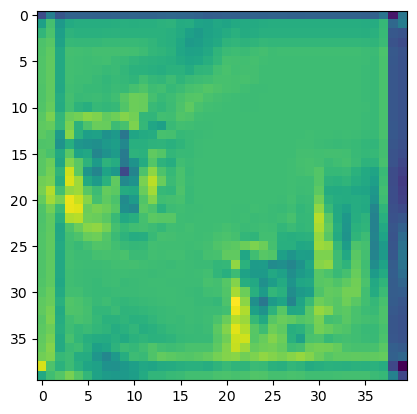

In [35]:
plt.imshow(track[15,:,:])